# AI-Powered Customer Support Ticket Analyzer

This notebook demonstrates LangGraph's **state management** and **conditional edges** by building a
customer support ticket processing pipeline. It processes a user's query through these stages:

1. **Query Classification**: Classifies the ticket into predefined categories (e.g., Billing, Technical, General Inquiry).
2. **Issue Extraction**: Extracts the key issue from the query (if relevant).
3. **Suggested Response Generation**: Provides a response template.
4. **Routing Based on Classification**: Different paths for technical and general queries.

Additionally, the notebook compares results from **Groq API** and **Gemini API**.

## Why Separate Graph Invocations for Different LLMs?
When working with multiple LLMs, such as **Groq** and **Gemini** in this example, invoking the same graph instance multiple times can lead to state retention issues. This is because LangGraph maintains execution states across invocations.

**SPECIAL NOTE**: This issue took a lot of my time even with ChatGPT 4o I could not solve it without my own intellect, making me believe that **AI takeover is not very near yet**! 😀

Using separate graph instances ensures that:
- Each model processes queries independently without unexpected state conflicts.
- Inputs and outputs are not accidentally mixed across different LLMs.
- Performance remains consistent by avoiding unintended state carry-over from previous executions.


## Set Up Your Environment

In [ ]:
# Install necessary packages
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community langchain-groq

## Import Necessary Modules

In [ ]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from IPython.display import display, Image
from google.colab import userdata
from langchain_groq import ChatGroq
import google.generativeai as genai

## Configure the API Key

In [ ]:
# Configure API Keys
GROQ_API_KEY = userdata.get("GROQ_API_KEY")
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

## Initialize the Model

In [ ]:
genai.configure(api_key=GEMINI_API_KEY)

groq_model = ChatGroq(model="llama3-70b-8192", api_key=GROQ_API_KEY)
gemini_model = genai.GenerativeModel("gemini-1.5-flash")

## Define the Text Processing Pipeline


In [ ]:
# Define the State Structure
class State(TypedDict):
    text: str
    classification_result: str
    issues: List[str]
    generated_response: str
    model_used: str

## Define Tool Functions

In [ ]:
# Define Tool Functions
@tool
def extract_issues(text: str, model: str) -> List[str]:
    """Extracts key issues from a support ticket."""
    prompt = f"Extract the key issues from the following support ticket:\n\n{text}\n\nIssues:"
    response = groq_model.invoke(prompt) if model == "groq" else gemini_model.generate_content(prompt)
    extracted_text = response.content if model == "groq" else response.text
    return extracted_text.strip().split(", ") if extracted_text else []

## Define Node Functions

In [ ]:
# Define Node Functions
def classify_query(state: State):
    """Classifies the user query into categories."""
    prompt = f"Classify the following customer query as one of these categories: Billing, Technical, General Inquiry.\n\nText:{state['text']}\n\nCategory:"
    model = groq_model if state['model_used'] == "groq" else gemini_model
    response = model.invoke(prompt) if state['model_used'] == "groq" else model.generate_content(prompt)
    extracted_text = response.content if state['model_used'] == "groq" else response.text
    return {"classification_result": extracted_text.strip() if extracted_text else "Unknown"}

def issue_extraction(state: State):
    """Extracts key issues from the query if it's technical."""
    return {"issues": extract_issues(state['text'], state['model_used'])}

def generate_response(state: State):
    """Generates a suggested response for the query."""
    prompt = f"Generate a response for the following support ticket:\n\nText:{state['text']}\n\nResponse:"
    model = groq_model if state['model_used'] == "groq" else gemini_model
    response = model.invoke(prompt) if state['model_used'] == "groq" else model.generate_content(prompt)
    extracted_text = response.content if state['model_used'] == "groq" else response.text
    return {"generated_response": extracted_text.strip() if extracted_text else "No response generated."}

def router(state: State):
    """Routes workflow based on classification."""
    return {"next_node": "issue_extraction" if state.get("classification_result", "") == "Technical" else "generate_response"}

## Create the Workflow Graph

In [ ]:
# Function to create a new instance of the graph
def create_workflow_graph():
    workflow = StateGraph(State)
    workflow.add_node("classify_query", classify_query)
    workflow.add_node("router", router)
    workflow.add_node("issue_extraction", issue_extraction)
    workflow.add_node("generate_response", generate_response)

    workflow.set_entry_point("classify_query")
    workflow.add_edge("classify_query", "router")
    workflow.add_conditional_edges("router", lambda state: state.get("next_node", "generate_response"))
    workflow.add_edge("issue_extraction", "generate_response")
    workflow.add_edge("generate_response", END)

    return workflow.compile()

## Visualize the Workflow

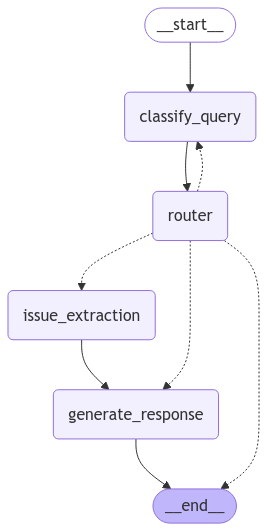

In [ ]:
# Ensure a new instance of the graph is created each time
graph1 = create_workflow_graph()
graph2 = create_workflow_graph()  # Separate instance for another run

display(Image(graph1.get_graph().draw_mermaid_png()))

## Test the Pipeline

In [ ]:
# Test the Pipeline with Groq API
print("\nUsing Groq API\n")
sample_query = "My internet disconnects unpredictably, sometimes for hours at a time, even when other devices on the same network remain connected."
state_input = {"text": sample_query, "model_used": "groq"}

# Invoke the first graph instance
result1 = graph1.invoke(state_input)
print(result1)


Using Groq API

{'text': 'My internet disconnects unpredictably, sometimes for hours at a time, even when other devices on the same network remain connected.', 'classification_result': 'The correct category for this customer query is: Technical', 'generated_response': "Dear [Customer],\n\nThank you for reaching out to us about the issues you're experiencing with your internet connection. I apologize for the inconvenience this has caused and I'm happy to help troubleshoot the problem.\n\nIt's unusual that your internet connection is disconnecting unpredictably, especially when other devices on the same network remain connected. To better understand the issue, could you please provide some more information?\n\n* What type of internet service do you have (e.g. DSL, Cable, Fiber)?\n* What is your router's make and model?\n* Have you noticed any patterns or triggers that might cause the disconnection (e.g. specific times of day, heavy usage, etc.)?\n* Have you tried restarting your router 

In [ ]:
# Test the Pipeline with Groq API
print("\nUsing Groq API\n")
sample_query = "What is my name?"
state_input = {"text": sample_query, "model_used": "groq"}

# Invoke the first graph instance
result3 = graph1.invoke(state_input)
print(result3)


Using Groq API

{'text': 'What is my name?', 'classification_result': 'Category: General Inquiry', 'generated_response': "I'm happy to help! However, I'm a large language model, I don't have access to personal information such as your name unless you've previously provided it to me. Could you please provide more context or clarify how I can assist you with your question?", 'model_used': 'groq'}


In [ ]:
# Test the Pipeline with Groq API
print("\nUsing Groq API\n")
sample_query = "I have two issues as i got over-billed and my net is not working?"
state_input = {"text": sample_query, "model_used": "groq"}

# Invoke the first graph instance
result4 = graph1.invoke(state_input)
print(result4)


Using Groq API

{'text': 'I have two issues as i got over-billed and my net is not working?', 'classification_result': 'The correct categorization for this customer query is:\n\n**Two categories: Billing and Technical**\n\nThe customer is complaining about being over-billed, which falls under the "Billing" category, and also mentions that their internet is not working, which falls under the "Technical" category.', 'generated_response': 'Here\'s a potential response:\n\n"Dear [Customer\'s Name],\n\nThank you for reaching out to us about the issues you\'re experiencing with your billing and internet service. I apologize for the inconvenience this has caused and I\'m happy to help resolve both matters for you.\n\nRegarding the over-billing issue, I\'ve gone ahead and reviewed your account and I see that there was an error on our part. I\'ve corrected the issue and you will receive a credit on your next bill. You will receive an email with the updated invoice shortly.\n\nAs for the intern

In [ ]:
# Test the Pipeline with Gemini API
print("\nUsing Gemini API\n")
sample_query = "My internet disconnects unpredictably, sometimes for hours at a time, even when other devices on the same network remain connected."
state_input = {"text": sample_query, "model_used": "gemini"}

# Invoke the second graph instance
result2 = graph2.invoke(state_input)
print(result2)


Using Gemini API

{'text': 'My internet disconnects unpredictably, sometimes for hours at a time, even when other devices on the same network remain connected.', 'classification_result': 'Category: Technical', 'generated_response': 'Subject: Re: Intermittent Internet Disconnections\n\nThank you for contacting us about your intermittent internet disconnections.  We understand how frustrating this can be, especially when other devices on your network remain connected.\n\nTo help us diagnose the issue, could you please provide the following information:\n\n* **Your account number:** (This helps us quickly access your account details.)\n* **The type of internet connection you have:** (e.g., DSL, Cable, Fiber, Satellite)\n* **The modem and router model numbers:** (This information is usually found on a sticker on the device.)\n* **A description of when the disconnections typically occur:** (e.g., at specific times of day, after a certain amount of usage, randomly)\n* **A list of devices th

In [ ]:
import json

# Function to pretty-print the results
def print_readable_output(result, model_name):
    print(f"\nUsing {model_name} API\n")
    print(json.dumps(result, indent=4, ensure_ascii=False))

# Print formatted results
print_readable_output(result1, "Groq")
print_readable_output(result2, "Gemini")
print_readable_output(result3, "Groq")
print_readable_output(result4, "Groq")



Using Groq API

{
    "text": "My internet disconnects unpredictably, sometimes for hours at a time, even when other devices on the same network remain connected.",
    "classification_result": "The correct category for this customer query is: Technical",
    "generated_response": "Dear [Customer],\n\nThank you for reaching out to us about the issues you're experiencing with your internet connection. I apologize for the inconvenience this has caused and I'm happy to help troubleshoot the problem.\n\nIt's unusual that your internet connection is disconnecting unpredictably, especially when other devices on the same network remain connected. To better understand the issue, could you please provide some more information?\n\n* What type of internet service do you have (e.g. DSL, Cable, Fiber)?\n* What is your router's make and model?\n* Have you noticed any patterns or triggers that might cause the disconnection (e.g. specific times of day, heavy usage, etc.)?\n* Have you tried restarting